In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet
import yfinance as yf
import os
import csv

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
## Set crypto variable
crypto = 'DOGE'
yf_crypto = 'DOGE'

# Set YF crypto symbol
symbol = f'{yf_crypto}-USD'

# Create crypto df
#crypto_df = f'{crypto}_df'.lower()

In [5]:
# Retreive max data
data = yf.Ticker(f'{symbol}')
history = data.history(period='max')

# Define file path and name
#filepath = f'~/crypto-forecast/resources/{crypto}-USD.csv'
#filepath = os.path.expanduser('~/crypto-forecast/resources/ADA-USD.csv')

# Create dataframe
crypto_df = pd.DataFrame(history)

# Set 'Date' as the index and parse dates
crypto_df.index = pd.to_datetime(crypto_df.index)

# Drop columns
crypto_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

# Drop last row
crypto_df = crypto_df.drop(crypto_df.tail(1).index)

# Drop rows with any NaN values
crypto_df.dropna(inplace=True)

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Drop timezone from datetime
crypto_df = crypto_df.reset_index()
crypto_df['Date'] = crypto_df['Date'].dt.tz_localize(None)
crypto_df.set_index('Date', inplace=True)

# Set file path to store data as a csv
csv_filepath = os.path.expanduser(f'~/crypto-forecast/resources/{crypto}-USD.csv')

# Write the DataFrame to a CSV file
crypto_df.to_csv(csv_filepath, index=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,0.001207,0.001415,0.001181,0.001415,6259550
2017-11-10,0.001421,0.001431,0.001125,0.001163,4246520
2017-11-11,0.001146,0.001257,0.001141,0.001201,2231080
2017-11-12,0.001189,0.001210,0.001002,0.001038,3288960
2017-11-13,0.001046,0.001212,0.001019,0.001211,2481270


,Open,High,Low,Close,Volume
Date,,,,,
2024-06-04,0.158282,0.161744,0.157163,0.161450,760727969
2024-06-05,0.161450,0.164724,0.161292,0.163235,820053785
2024-06-06,0.163235,0.165170,0.158657,0.160159,893170339
2024-06-07,0.160158,0.162019,0.143118,0.148303,1581768204
2024-06-08,0.148296,0.148583,0.144010,0.146059,872877278


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

0.14605900645256042

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.993850,0.993712,0.992498,0.547845
High,0.993850,1.000000,0.986473,0.995102,0.613288
Low,0.993712,0.986473,1.000000,0.994566,0.512007
Close,0.992498,0.995102,0.994566,1.000000,0.581027
Volume,0.547845,0.613288,0.512007,0.581027,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2017-11-09,0.001415,6259550
2017-11-10,0.001163,4246520
2017-11-11,0.001201,2231080
2017-11-12,0.001038,3288960
2017-11-13,0.001211,2481270
...,...,...
2024-06-04,0.161450,760727969
2024-06-05,0.163235,820053785
2024-06-06,0.160159,893170339


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate volatility
df_close_ma.loc[:, 'Percent Change'] = df_close_ma['Close'].pct_change()*100
df_close_ma.loc[:, 'Volatility'] = df_close_ma['Percent Change'].rolling(10).std(ddof=0) * np.sqrt(252)

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2017-12-28,0.008486,51201500,0.007735,0.004723,0.003451
2017-12-29,0.009391,62474900,0.008107,0.004966,0.003610
2017-12-30,0.007860,56175300,0.008227,0.005159,0.003744
2017-12-31,0.008972,62256400,0.008382,0.005386,0.003900
2018-01-01,0.008909,50616900,0.008667,0.005612,0.004057


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-06-04,0.161450,760727969,0.161978,0.156888,0.154252
2024-06-05,0.163235,820053785,0.161679,0.157109,0.154397
2024-06-06,0.160159,893170339,0.160786,0.157441,0.154648
2024-06-07,0.148303,1581768204,0.159121,0.157608,0.154565
2024-06-08,0.146059,872877278,0.157357,0.157406,0.154361


<Axes: xlabel='Date'>

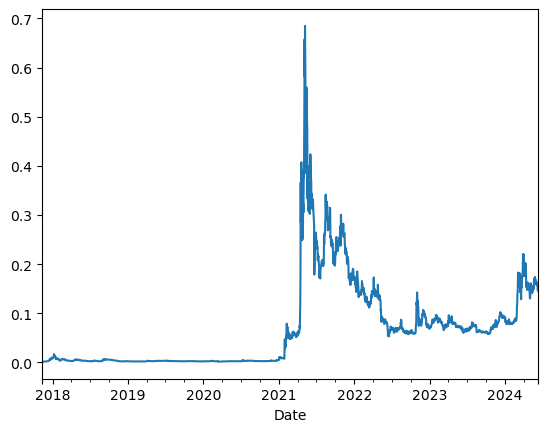

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2017-11-09,0.001415,6259550
1,2017-11-10,0.001163,4246520
2,2017-11-11,0.001201,2231080
3,2017-11-12,0.001038,3288960
4,2017-11-13,0.001211,2481270
...,...,...,...
2399,2024-06-04,0.161450,760727969
2400,2024-06-05,0.163235,820053785
2401,2024-06-06,0.160159,893170339
2402,2024-06-07,0.148303,1581768204


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

16:42:23 - cmdstanpy - INFO - Chain [1] start processing
16:42:24 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
2489,2024-09-02
2490,2024-09-03
2491,2024-09-04
2492,2024-09-05
2493,2024-09-06


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2464,2024-08-08,0.131569,0.077843,0.167559,0.126273,0.137181,-0.006482,-0.006482,-0.006482,-0.000316,-0.000316,-0.000316,-0.006166,-0.006166,-0.006166,0.0,0.0,0.0,0.125087
2465,2024-08-09,0.131692,0.083829,0.172527,0.126302,0.137495,-0.004574,-0.004574,-0.004574,0.000467,0.000467,0.000467,-0.005041,-0.005041,-0.005041,0.0,0.0,0.0,0.127118
2466,2024-08-10,0.131814,0.084573,0.172108,0.126119,0.137845,-0.003584,-0.003584,-0.003584,0.000345,0.000345,0.000345,-0.003929,-0.003929,-0.003929,0.0,0.0,0.0,0.128230
2467,2024-08-11,0.131937,0.085384,0.174473,0.126054,0.138196,-0.002494,-0.002494,-0.002494,0.000349,0.000349,0.000349,-0.002843,-0.002843,-0.002843,0.0,0.0,0.0,0.129443
2468,2024-08-12,0.132059,0.085729,0.172846,0.125968,0.138503,-0.001827,-0.001827,-0.001827,-0.000030,-0.000030,-0.000030,-0.001797,-0.001797,-0.001797,0.0,0.0,0.0,0.130232
2469,2024-08-13,0.132182,0.085147,0.174005,0.125959,0.138781,-0.001220,-0.001220,-0.001220,-0.000414,-0.000414,-0.000414,-0.000806,-0.000806,-0.000806,0.0,0.0,0.0,0.130962
2470,2024-08-14,0.132305,0.090244,0.172615,0.125933,0.139097,-0.000282,-0.000282,-0.000282,-0.000400,-0.000400,-0.000400,0.000118,0.000118,0.000118,0.0,0.0,0.0,0.132022
2471,2024-08-15,0.132427,0.092052,0.175761,0.125908,0.139510,0.000646,0.000646,0.000646,-0.000316,-0.000316,-0.000316,0.000962,0.000962,0.000962,0.0,0.0,0.0,0.133073
2472,2024-08-16,0.132550,0.094313,0.178478,0.125635,0.139972,0.002183,0.002183,0.002183,0.000467,0.000467,0.000467,0.001715,0.001715,0.001715,0.0,0.0,0.0,0.134732
2473,2024-08-17,0.132672,0.091273,0.178203,0.125472,0.140466,0.002714,0.002714,0.002714,0.000345,0.000345,0.000345,0.002369,0.002369,0.002369,0.0,0.0,0.0,0.135386


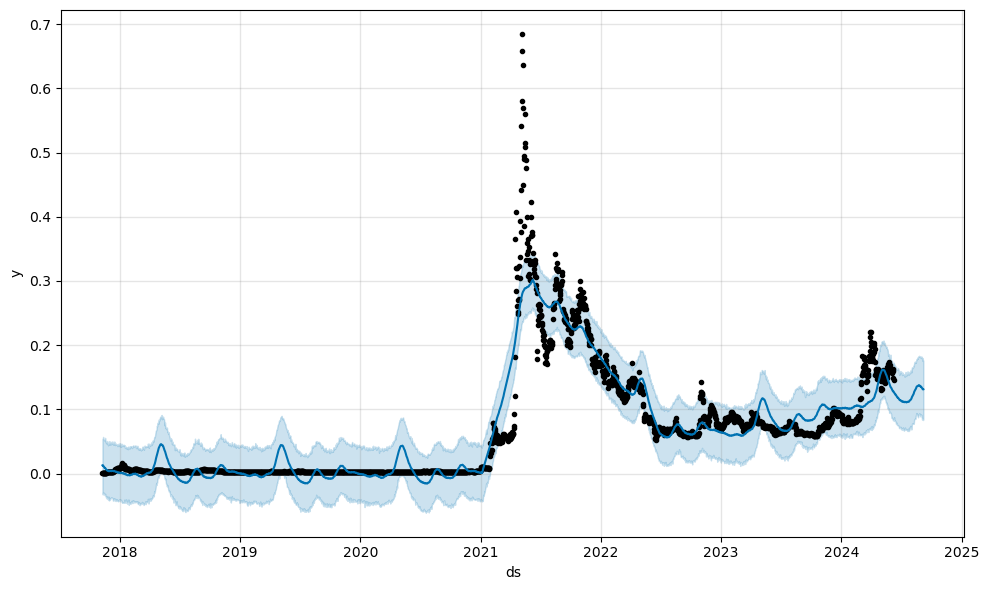

In [20]:
# Plot the Prophet predictions for the data
crypto_model.plot(crypto_forecast)
plt.savefig(f'{crypto}_forecast', bbox_inches = 'tight')

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-06-09,0.126523,0.087898,0.171049
2024-06-10,0.125425,0.081832,0.169611
2024-06-11,0.124327,0.081973,0.166711
2024-06-12,0.123629,0.082672,0.167991
2024-06-13,0.123002,0.081793,0.165339
...,...,...,...
2024-09-02,0.133247,0.084122,0.180274
2024-09-03,0.132226,0.086555,0.175824
2024-09-04,0.131610,0.085644,0.179600


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

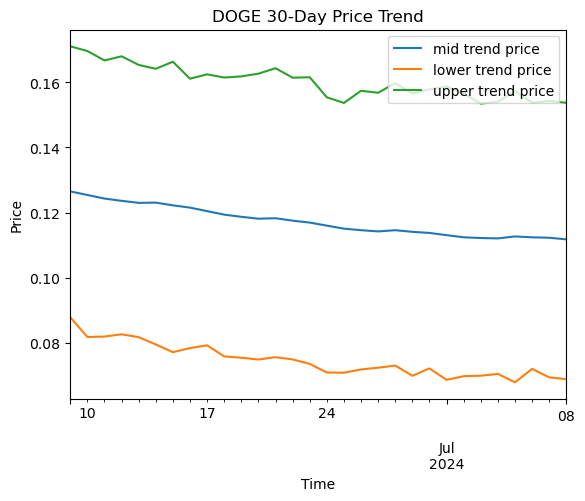

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

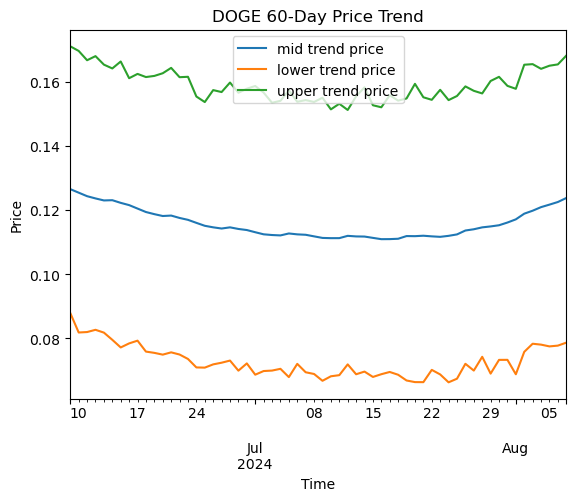

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

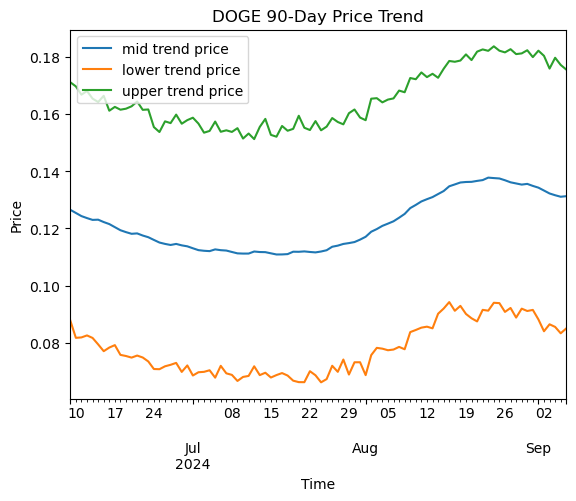

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

0.14605900645256042

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

0.12652292462500123

In [29]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

0.13629096553878084

In [30]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

0.1277031264851857

In [31]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

0.11114976636836398

In [32]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

0.12413251720905376

In [33]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

0.13088510661178593

In [34]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

-0.184

In [35]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

-0.089

In [36]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

-0.04

In [37]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

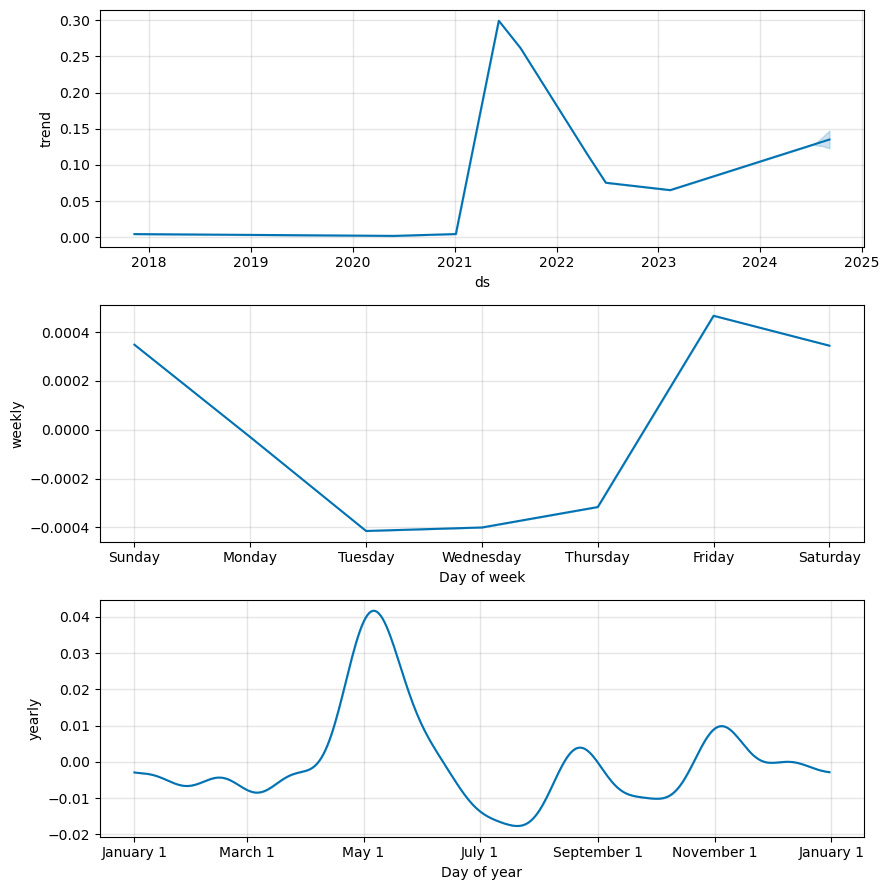

In [38]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig_comp = crypto_model.plot_components(crypto_forecast)
plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

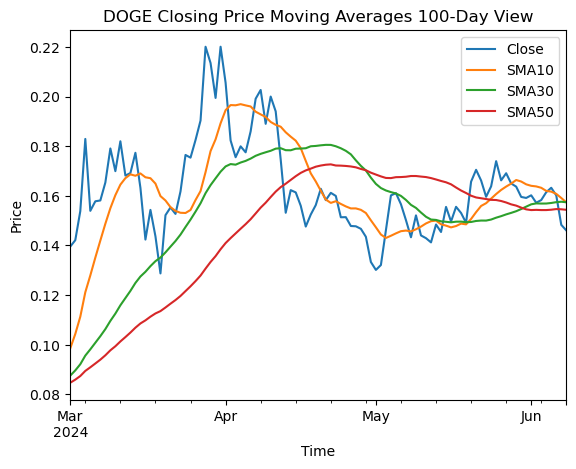

In [39]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

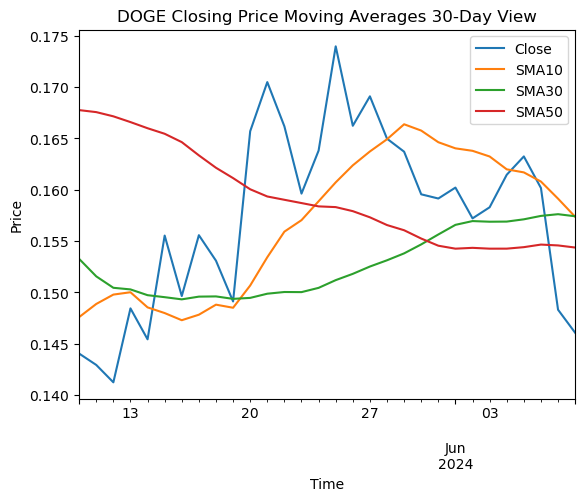

In [40]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')  
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [41]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-06-09
File created :  2024-06-09.csv


In [42]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [43]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.43657100200653076,-0.07364667494769794,-0.0009456964793739253,0.3544596118546628
ADA,0.43657100200653076,-0.08437373181845453,0.002834181787628731,0.36173019111251126
ADA,0.43657100200653076,-0.08372637062435029,0.0025919668069758206,0.3631142967037635
ADA,0.43657100200653076,-0.0783190338427533,0.004381382002310641,0.36321329122708335
ATOM,7.759523868560791,-0.2525451407294217,-0.22995154564524733,0.08676291965413196
AVAX,32.29003143310547,-0.06238204683353343,0.016250905637703372,0.184324988794629
AVAX,32.29003143310547,-0.061383912293528464,0.006255814491331391,0.188757389641659
BNB,682.6651611328125,-0.25945675235825627,-0.21619087415535265,-0.19462572272913758
BONK,2.700000004551839e-05,0.19694570130627698,0.3277996886564134,0.4415377509818921
BTC,69305.7734375,-0.1351637782567381,-0.09261706566887273,-0.09372540555309616
DOGE,0.14605900645256042,-0.18446710000937716,-0.08920949588743987,-0.03966410323402325

